In [19]:
import os
import json
from IPython.display import display, clear_output
import subprocess
from pydub import AudioSegment
import openai
from io import BytesIO
import base64
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import platform
import ast
import csv
import cv2
import ast
import ipywidgets as widgets
from IPython.display import display

BASE_DIR = os.getcwd()
PROGRESS_FILE = os.path.abspath(os.path.join(BASE_DIR, "progress.json"))
VIDEOS_FOLDER = os.path.abspath(os.path.join(BASE_DIR, "../data/static-videos/Dilshod Ochilov"))
CSV_PATH = os.path.abspath(os.path.join(BASE_DIR, "../data/static_videos.csv"))


Video folder manager. To track which videos within input folder where already checked. This script process next video from passed folder pass that is not marked as compleated at process.json

In [66]:

def load_progress(progress_file):
    if os.path.exists(progress_file):
        try:
            with open(progress_file, "r") as f:
                return json.load(f)
        except json.JSONDecodeError:
            print(f"⚠️ Warning: {progress_file} is empty or corrupted. Starting fresh.")
            return {}
    return {}

def list_videos(folder):
    exts = {".mp4", ".mov", ".avi", ".mkv"}
    videos = []
    if not os.path.exists(folder):
        print(f"⚠️ Videos folder not found: {folder}")
        return videos
    for f in os.listdir(folder):
        if os.path.splitext(f)[1].lower() in exts:
            full_path = os.path.abspath(os.path.join(folder, f))
            if os.path.isfile(full_path):
                videos.append(full_path)
    return sorted(videos)

def load_csv_info(csv_path):
    info = {}
    if not os.path.exists(csv_path):
        print(f"⚠️ CSV file not found: {csv_path}")
        return info
    with open(csv_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            video_name = row.get("video_name")
            if video_name:
                key = os.path.splitext(video_name)[0]
                info[key] = {
                    "collector_name": row.get("collector_name", ""),
                    "material": row.get("material", ""),
                    "duration": row.get("duration", "")
                }
    return info

def select_next_video_with_info(folder, progress_file, csv_path):
    progress = load_progress(progress_file)
    
    processed_basenames = set()
    for video_path, data in progress.items():
        if isinstance(data, dict) and data.get("status") == "done":
            base = os.path.splitext(os.path.basename(video_path))[0]
            processed_basenames.add(base)
    
    videos = list_videos(folder)
    csv_info = load_csv_info(csv_path)

    for video_path in videos:
        base_no_ext = os.path.splitext(os.path.basename(video_path))[0]
        if base_no_ext not in processed_basenames:
            info = csv_info.get(base_no_ext)
            return video_path, info

    return None, None

next_video, video_info = select_next_video_with_info(VIDEOS_FOLDER, PROGRESS_FILE, CSV_PATH)

if next_video:
    print("Next video to process:", next_video)
    if video_info:
        print("Video info from CSV:")
        print(f"  Collector Name: {video_info['collector_name']}")
        print(f"  Material: {video_info['material']}")
        print(f"  Duration: {video_info['duration']}")
    else:
        print("No CSV info found for this video.")
else:
    print("🎉 All videos processed!")


Next video to process: /Users/aleksadianka/Desktop/CCNY/SideWALK/algorithms/legacy_sidewalk_data_labelbox/data/static-videos/Dilshod Ochilov/2022-10-27_10-29-09-9300_Concrete.mp4
Video info from CSV:
  Collector Name: Dilshod Ochilov
  Material: concrete
  Duration: 33.04


Auto check if video contain sounds and if it isn't silent

In [22]:
# Your existing functions for loading progress, listing videos, and csv info...
# (Assuming they are already defined in the notebook)

def has_audio(video_path):
    cmd = [
        "ffprobe", "-i", video_path,
        "-show_streams", "-select_streams", "a",
        "-loglevel", "error"
    ]
    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return bool(result.stdout.strip())

def is_audio_silent(video_path, silence_threshold=-50.0):
    audio = AudioSegment.from_file(video_path)
    return audio.dBFS < silence_threshold

# Select next video
next_video, video_info = select_next_video_with_info(VIDEOS_FOLDER, PROGRESS_FILE, CSV_PATH)

if next_video is None:
    print("🎉 All videos processed!")
else:
    print("Next video to process:", next_video)
    if video_info:
        print(f"Collector: {video_info['collector_name']}")
        print(f"Material: {video_info['material']}")
        print(f"Duration: {video_info['duration']}")
    else:
        print("No CSV info found for this video.")

    # Now check audio presence and silence
    if not has_audio(next_video):
        print("❌ No audio track found.")
    else:
        if is_audio_silent(next_video):
            print("🔇 Audio track is present but silent.")
        else:
            print("🔊 Audio track contains sound.")


Next video to process: /Users/aleksadianka/Desktop/CCNY/SideWALK/algorithms/legacy_sidewalk_data_labelbox/data/static-videos/Dilshod Ochilov/2022-10-27_10-20-22-4230_Manhole.mp4
Collector: Dilshod Ochilov
Material: manhole
Duration: 32.77
🔊 Audio track contains sound.


Additional check if first and last second is not silent:

In [40]:
def is_segment_silent(audio_segment, silence_threshold=-50.0):
    return audio_segment.dBFS < silence_threshold

def check_silence_edges(video_path, silence_threshold=-50.0, segment_duration_ms=1000):
    audio = AudioSegment.from_file(video_path)
    duration_ms = len(audio)
    if duration_ms < 2 * segment_duration_ms:
        # Video too short to check both ends separately; check whole audio
        return is_segment_silent(audio, silence_threshold), is_segment_silent(audio, silence_threshold)
    
    start_segment = audio[:segment_duration_ms]
    end_segment = audio[-segment_duration_ms:]
    
    start_silent = is_segment_silent(start_segment, silence_threshold)
    end_silent = is_segment_silent(end_segment, silence_threshold)
    
    return start_silent, end_silent

if not has_audio(next_video):
    print("❌ No audio track found.")
else:
    start_silent, end_silent = check_silence_edges(next_video)
    
    if start_silent:
        print("🔇 First 1 second of audio is silent.")
    else:
        print("🔊 First 1 second of audio contains sound.")
        
    if end_silent:
        print("🔇 Last 1 second of audio is silent.")
    else:
        print("🔊 Last 1 second of audio contains sound.")
    
    # Optional: overall silence check too
    if is_audio_silent(next_video):
        print("🔇 Audio track overall is silent.")
    else:
        print("🔊 Audio track overall contains sound.")


🔊 First 1 second of audio contains sound.
🔊 Last 1 second of audio contains sound.
🔊 Audio track overall contains sound.


Open video on computer to double check audio:

In [57]:
def open_video_default_player(filepath):
    if not os.path.isfile(filepath):
        print(f"❌ File does not exist: {filepath}")
        return
    
    system = platform.system()
    
    try:
        if system == "Darwin":  # macOS
            subprocess.run(["open", filepath])
        elif system == "Windows":
            os.startfile(filepath)  # only on Windows
        elif system == "Linux":
            subprocess.run(["xdg-open", filepath])
        else:
            print(f"❌ Unsupported OS: {system}")
    except Exception as e:
        print(f"❌ Failed to open video: {e}")
        
open_video_default_player(next_video)

If there is any problem with audio mark video invalid and add reason:

In [55]:
# New button for marking invalid
PROGRESS_FILE = "progress.json"

# Load progress or start fresh
if os.path.exists(PROGRESS_FILE):
    with open(PROGRESS_FILE, "r") as f:
        try:
            progress = json.load(f)
        except json.JSONDecodeError:
            progress = {}
else:
    progress = {}

# UI widgets
btn_mark_invalid = widgets.Button(description="Mark as invalid ❌", button_style="danger")
txt_invalid_reason = widgets.Text(
    placeholder='Enter reason why this video is invalid',
    description='Reason:',
    layout=widgets.Layout(width='100%')
)
btn_mark_done = widgets.Button(description="Mark this video as completed ✅", button_style="success")
lbl_video_path = widgets.HTML()
lbl_completed_list = widgets.HTML()
out_msg = widgets.Output()

# Current video state - set your next video path here manually or from other logic
current_state = {
    "next_video": None,
}

# For demonstration, assign a sample video path
current_state["next_video"] = next_video

# Simple UI refresh to show current video and completed list
def refresh_ui():
    if current_state["next_video"]:
        lbl_video_path.value = f"<b>Current video:</b> {current_state['next_video']}"
    else:
        lbl_video_path.value = "<b>No video selected.</b>"
    
    # Show completed and invalid videos
    completed = []
    invalid = []
    for v, data in progress.items():
        if isinstance(data, dict):
            if data.get("status") == "done":
                completed.append(os.path.basename(v))
            elif data.get("status") == "invalid":
                invalid.append(f"{os.path.basename(v)} (Reason: {data.get('reason', 'No reason')})")
        elif data is True:
            completed.append(os.path.basename(v))
    html_parts = []
    if completed:
        html_parts.append("<b>Completed videos:</b><ul>" + "".join(f"<li>{v}</li>" for v in completed) + "</ul>")
    if invalid:
        html_parts.append("<b>Invalid videos:</b><ul>" + "".join(f"<li>{v}</li>" for v in invalid) + "</ul>")
    if not html_parts:
        lbl_completed_list.value = "<i>No videos processed yet.</i>"
    else:
        lbl_completed_list.value = "".join(html_parts)

    with out_msg:
        out_msg.clear_output()
DATA_ROOT = "/Users/aleksadianka/Desktop/CCNY/SideWALK/algorithms/legacy_sidewalk_data_labelbox/data"
DATA_PREFIX = "/data"

def to_data_path(path):
    # Convert absolute or relative path into /data/... form
    path = os.path.normpath(path)
    if path.startswith(DATA_ROOT):
        return os.path.join(DATA_PREFIX, os.path.relpath(path, DATA_ROOT))
    return path

def mark_invalid_clicked(b):
    if current_state["next_video"]:
        reason = txt_invalid_reason.value.strip()
        if not reason:
            with out_msg:
                out_msg.clear_output()
                print("⚠️ Please enter a reason for marking invalid.")
            return

        video_path = to_data_path(current_state["next_video"])
        progress[video_path] = {
            "status": "invalid",
            "reason": reason
        }
        with open(PROGRESS_FILE, "w") as f:
            json.dump(progress, f, indent=2)

        with out_msg:
            out_msg.clear_output()
            print(f"Marked invalid: {video_path}")
            print(f"Reason: {reason}")
            print(f"Progress saved to: {PROGRESS_FILE}")

        refresh_ui()




btn_mark_invalid.on_click(mark_invalid_clicked)

container = widgets.VBox([
    lbl_video_path,
    txt_invalid_reason,
    btn_mark_invalid,
    lbl_completed_list,
    out_msg
])

display(container)
refresh_ui()

Opens the video and counts total frames.
Seeks to the middle frame.
Reads and shows that frame in a window.
Press any key to close the window.

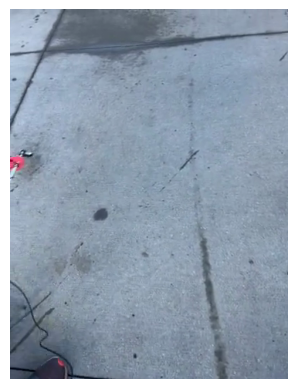

In [67]:
def get_middle_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Cannot open video: {video_path}")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        print("❌ Video has zero frames.")
        cap.release()
        return None

    middle_frame_idx = total_frames // 2
    cap.set(cv2.CAP_PROP_POS_FRAMES, middle_frame_idx)

    ret, frame = cap.read()
    cap.release()
    if not ret:
        print("❌ Failed to read the middle frame.")
        return None
    
    # Convert to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame_rgb

# Use your previously selected video path
middle_frame_img = None
if 'next_video' in globals() and next_video is not None:
    middle_frame_img = get_middle_frame(next_video)
    if middle_frame_img is not None:
        plt.imshow(middle_frame_img)
        plt.axis('off')
        plt.show()
else:
    print("No next_video variable found or it is None.")


Python script that calls an LLM (like OpenAI’s GPT-4) with your detailed system prompt and user prompt, sending in an image description or an image URL for annotation. Upload the extracted middle frame somewhere online (e.g., image hosting, S3) and pass its URL as image_info in the prompt.

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""

In [35]:
openai.api_key = os.getenv("OPENAI_API_KEY")

SYSTEM_PROMPT = """
You are an expert image annotation assistant specializing in sidewalk accessibility. Your task is to analyze an image of a sidewalk surface, often observed from the perspective of a person using a white cane, and provide a detailed multi-label annotation.

You must strictly adhere to the following three-part labeling schema.

**IMPORTANT:**
Your **only** output must be a single list containing the selected labels in the exact format:

`[$label1$, $label2$, $label3$]`

No explanations or extra text should be included.

---

### **Annotation Schema**

#### **Part 1: Material**
This category defines the primary substance the surface is made of.
*(REQUIRED, single selection)*

| Label | Description |
| :--- | :--- |
| `$concrete$` | The most common sidewalk material; typically gray and uniform. |
| `$asphalt$` | Black or dark gray paving material, often used for roads or patched areas. |
| `$metal$` | Includes steel, iron, or aluminum. Common for covers, grates, and plates. |
| `$brick$` | Fired clay blocks, typically reddish-brown, laid in a pattern. |
| `$stone$` | Natural quarried stone, such as granite or slate slabs. |
| `$wood$` | Wooden planks, found on boardwalks, park paths, or temporary walkways. |
| `$rubber$` | Rubberized surfaces found in playgrounds, temporary ramps, or safety mats. |
| `$soil_dirt$` | Unpaved earth or dirt paths. |
| `$gravel$` | A surface composed of small, loose stones. |
| `$grass$` | A surface covered in grass. |
| `$plastic$` | A plastic material often as part of tactile pavement. |
| `$other$` | A type of material not any of the other options specified. |

---

#### **Part 2: Physical Structure**  
This category describes the macroscopic construction and condition of the surface.  
*(REQUIRED, multiple selection)*  

| Label | Description |
| :--- | :--- |
| `$monolithic$` | A single, uniform surface without seams or repeating patterns. This applies to standard concrete slabs and smooth metal objects like a flat manhole cover. |
| `$tiled$` | A surface constructed from individual units (tiles, bricks, pavers) with joints between them. |
| `$tactile_pattern$` | A raised, detectable pattern specifically for tactile feedback (e.g., truncated domes). |
| `$grated_pattern$` | An open, latticed, or barred pattern that a cane tip can enter or detect. |
| `$loose$` | The surface is composed of non-fixed particles like gravel or sand. |
| `$expansion_joint$` | A deliberate, often filled, gap between large concrete slabs to allow for thermal expansion. |
| `$cracked_uneven$` | The surface has irregular cracks or fractures due to damage or age, or tiles/slabs are loose or tilted, creating an irregular, bumpy surface. |
| `$other$` | Structure does not fit the other categories. |

**Selection Guidance (use in combination with visual evidence from the cane contact zone):**  
- **If Material = `$asphalt$`, `$concrete$`, `$soil_dirt$`, or `$grass$`** → Select `$monolithic$` unless there are clearly visible tiles, grates, or joints.  
- **If Material = `$brick$`** or **Object = `$tactile pavement$` or `$cellar door$`** → Select `$tiled$`.  
- **If Object = `$grate (subway grate)$`** → Select `$grated_pattern$`.  
- **If Material = `$gravel$`** → Select `$loose$`.  
- **`$cracked_uneven$`** may be added **in addition** to other structures whenever visible cracks, displacement, or damage is present.  

#### **Part 3: Object / Component / Landmark**
This category identifies specific, functional objects embedded within or part of the sidewalk.
*(OPTIONAL, single selection)*

| Label | Description |
| :--- | :--- |
| `$manhole$` | A removable plate, typically metal, covering an underground utility vault. |
| `$grate (subway grate)$` | A cover with parallel or latticed bars, used for drainage or ventilation. |
| `$cellar door$` | Doors, typically metal and sloped, provide access to a basement from the sidewalk. |
| `$ramp$` | A sloped surface providing a transition from the sidewalk to the street level. |
| `$tactile pavement$` | A surface of detectable warning pavers (e.g., truncated domes at a crosswalk). |
| `$construction plate$`| A large, heavy metal plate temporarily covering an excavation site. |


"""

USER_PROMPT = """
Using the annotation schema and physical structure guidance provided, please analyze the image below.

The image shows a sidewalk with a white cane, which has a red tip at its end. 
Focus **only** on the area immediately surrounding the red tip of the cane — this is the exact contact point to analyze.

Identify:
1. The **material** of the surface at that point.
2. The **physical structure** of the surface at that point, using the guidance rules for likely co-occurrences between material, object, and structure.
3. Any **object/component/landmark** that is located exactly where the red tip touches.

**Output ONLY the list of labels exactly as specified in the schema.**
"""



def call_annotation_llm(image_pil):
    buffered = BytesIO()
    image_pil.save(buffered, format="JPEG")
    img_b64 = base64.b64encode(buffered.getvalue()).decode()

    try:
        response = openai.chat.completions.create(
            model="gpt-4.1-mini",
            messages=[
                {
                    "role": "system",
                    "content": SYSTEM_PROMPT
                },
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": USER_PROMPT},
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_b64}"}}
                    ]
                }
            ],
            temperature=0
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"API call failed: {e}"

# === Example usage ===

# Suppose middle_frame_img is a NumPy array (OpenCV format: H x W x C, BGR)
middle_frame_rgb = cv2.cvtColor(middle_frame_img, cv2.COLOR_BGR2RGB)
middle_frame_pil = Image.fromarray(middle_frame_rgb)

def parse_labels(raw_labels):
    clean = raw_labels.replace('$', '').replace('"', '').replace("'", "")
    clean = clean.strip('[]')
    items = [item.strip() for item in clean.split(',') if item.strip()]
    return items

labels_raw = call_annotation_llm(middle_frame_pil)
labels = parse_labels(labels_raw)

# labels is a Python list of strings:
print(labels)  
# Output: ['asphalt', 'cracked_uneven']

# Formatted string WITHOUT quotes (for saving/display):
labels_str = f"[{', '.join(labels)}]"
print(labels_str)  
# Output: [asphalt, cracked_uneven]



['metal', 'monolithic', 'manhole']
[metal, monolithic, manhole]


If some of the label is wrong, there is a tool to correct it:

In [36]:
if isinstance(labels, str):
    # Replace backticks with quotes, then parse string to list
    labels_str_fixed = labels.replace("`", "'")
    labels_list = ast.literal_eval(labels_str_fixed)
    labels = labels_list  # now a list
elif isinstance(labels, list):
    # Already a list, nothing to do
    labels_list = labels
else:
    raise TypeError(f"Unexpected type for labels: {type(labels)}")

# Prepare editable string for textarea (without backticks)
editable_labels_str = ", ".join(labels_list)

txt_labels_edit = widgets.Textarea(
    value=editable_labels_str,
    placeholder="Edit labels separated by commas",
    description="Labels:",
    layout=widgets.Layout(width='100%', height='80px'),
)

out_edit_labels = widgets.Output()

def save_labels_clicked(b):
    new_text = txt_labels_edit.value
    new_labels = [lbl.strip() for lbl in new_text.split(",") if lbl.strip()]

    global labels
    
    # Convert list of labels back into string format with backticks and brackets:
    labels_with_ticks = [f"`{lbl}`" for lbl in new_labels]
    labels = "[" + ", ".join(labels_with_ticks) + "]"

    with out_edit_labels:
        clear_output()
        print("Saved labels (string format):", labels)

btn_save_labels = widgets.Button(description="Save labels ✏️")
btn_save_labels.on_click(save_labels_clicked)

display(txt_labels_edit, btn_save_labels, out_edit_labels)

Textarea(value='metal, monolithic, manhole', description='Labels:', layout=Layout(height='80px', width='100%')…

Button(description='Save labels ✏️', style=ButtonStyle())

Output()

Mark current video as compleated:

In [65]:
print(f"Using videos folder: {VIDEOS_FOLDER}")
print(f"Using progress file: {PROGRESS_FILE}")
print(f"Using CSV file: {CSV_PATH}")

def to_relative_data_path(abs_path):
    """Convert absolute path to normalized /data/... path with forward slashes."""
    abs_path = os.path.normpath(abs_path)
    parts = abs_path.split(os.sep)
    if "data" in parts:
        data_idx = parts.index("data")
        rel_parts = parts[data_idx:]
        rel_path = os.path.join(*rel_parts)
        return "/" + rel_path.replace(os.sep, "/")
    else:
        return os.path.basename(abs_path)

def load_progress(progress_file):
    if os.path.exists(progress_file):
        try:
            with open(progress_file, "r") as f:
                data = json.load(f)
            # Normalize keys to /data/... format
            normalized = {to_relative_data_path(k): v for k, v in data.items()}
            print(f"Loaded progress with {len(normalized)} entries")
            return normalized
        except json.JSONDecodeError:
            print(f"⚠️ Warning: {progress_file} is empty or corrupted. Starting fresh.")
            return {}
    else:
        print(f"Progress file not found, starting fresh.")
        return {}

def list_videos(folder):
    exts = {".mp4", ".mov", ".avi", ".mkv"}
    if not os.path.exists(folder):
        print(f"⚠️ Videos folder not found: {folder}")
        return []
    videos = []
    for f in os.listdir(folder):
        if os.path.splitext(f)[1].lower() in exts:
            full_path = os.path.abspath(os.path.join(folder, f))
            full_path = os.path.normpath(full_path)
            if os.path.isfile(full_path):
                videos.append(full_path)
    return sorted(videos)

def load_csv_info(csv_path):
    info = {}
    if not os.path.exists(csv_path):
        print(f"⚠️ CSV file not found: {csv_path}")
        return info
    with open(csv_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            video_name = row.get("video_name")
            if video_name:
                info[video_name] = {
                    "collector_name": row.get("collector_name", ""),
                    "material": row.get("material", ""),
                    "duration": row.get("duration", "")
                }
    return info

def clean_labels_string(labels_str):
    cleaned = labels_str.replace("`", "'")
    return ast.literal_eval(cleaned)

def get_video_frame_range_and_seconds(video_path, assumed_fps=30):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Cannot open video: {video_path}")
        return None, None, None, None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 0:
        fps = assumed_fps

    start_frame = 0
    end_frame = total_frames - 1 if total_frames > 0 else None
    start_sec = start_frame / fps if start_frame is not None else None
    end_sec = end_frame / fps if end_frame is not None else None
    cap.release()
    return start_frame, end_frame, start_sec, end_sec

# Load data
progress = load_progress(PROGRESS_FILE)
csv_info = load_csv_info(CSV_PATH)
videos = list_videos(VIDEOS_FOLDER)

# Example labels string and parsed labels list (replace this as needed)
labels_str = "[`gravel`, `test`]"
labels = clean_labels_string(labels_str)

# Widgets setup
btn_mark_done = widgets.Button(description="Mark this video as completed ✅", button_style="success")
lbl_video_path = widgets.HTML()
lbl_collector = widgets.HTML()
lbl_material = widgets.HTML()
lbl_duration = widgets.HTML()
lbl_completed_list = widgets.HTML()
out_msg = widgets.Output()

container = widgets.VBox([
    lbl_video_path,
    lbl_collector,
    lbl_material,
    lbl_duration,
    btn_mark_done,
    lbl_completed_list,
    out_msg
])

current_state = {"next_video": None, "video_info": None, "rel_video_path": None}

def get_completed_videos_list():
    completed = []
    invalid = []
    for v, data in progress.items():
        if isinstance(data, dict):
            if data.get("status") == "done":
                completed.append(os.path.basename(v))
            elif data.get("status") == "invalid":
                invalid.append(f"{os.path.basename(v)} (Reason: {data.get('reason', 'No reason')})")
        elif data is True:
            completed.append(os.path.basename(v))

    html_parts = []
    if completed:
        html_parts.append("<b>Completed videos:</b><ul>" + "".join(f"<li>{v}</li>" for v in completed) + "</ul>")
    if invalid:
        html_parts.append("<b>Invalid videos:</b><ul>" + "".join(f"<li>{v}</li>" for v in invalid) + "</ul>")
    if not html_parts:
        return "<i>No videos processed yet.</i>"
    return "".join(html_parts)

def refresh_ui():
    current_state["next_video"] = None
    current_state["video_info"] = None
    current_state["rel_video_path"] = None

    if not videos:
        with out_msg:
            out_msg.clear_output()
            print("⚠️ No videos found in the specified folder.")
        return

    for v in videos:
        norm_v = os.path.normpath(v)
        rel_v = to_relative_data_path(norm_v)
        if not progress.get(rel_v, False):
            current_state["next_video"] = v
            current_state["rel_video_path"] = rel_v

            filename_no_ext = os.path.splitext(os.path.basename(v))[0]

            # Match CSV info ignoring extension
            current_state["video_info"] = None
            for csv_name, csv_data in csv_info.items():
                if os.path.splitext(csv_name)[0] == filename_no_ext:
                    current_state["video_info"] = csv_data
                    break
            break

    if current_state["next_video"]:
        lbl_video_path.value = f"<b>Next video:</b> {current_state['next_video']}"
        if current_state["video_info"]:
            lbl_collector.value = f"<b>Collector:</b> {current_state['video_info'].get('collector_name', 'N/A')}"
            lbl_material.value = f"<b>Material:</b> {current_state['video_info'].get('material', 'N/A')}"
            lbl_duration.value = f"<b>Duration:</b> {current_state['video_info'].get('duration', 'N/A')}"
        else:
            lbl_collector.value = lbl_material.value = lbl_duration.value = "<i>No CSV info found.</i>"
        lbl_completed_list.value = get_completed_videos_list()
        btn_mark_done.disabled = False
    else:
        lbl_video_path.value = ""
        lbl_collector.value = ""
        lbl_material.value = ""
        lbl_duration.value = ""
        lbl_completed_list.value = "<b>All videos completed! 🎉</b>" + get_completed_videos_list()
        btn_mark_done.disabled = True

    with out_msg:
        out_msg.clear_output()

def mark_done_clicked(b):
    if current_state["next_video"]:
        abs_video_path = os.path.normpath(current_state["next_video"])
        rel_video_path = current_state.get("rel_video_path", to_relative_data_path(abs_video_path))

        start_frame, end_frame, start_sec, end_sec = get_video_frame_range_and_seconds(abs_video_path)

        existing_entry = progress.get(rel_video_path, {})
        filename_no_ext = os.path.splitext(os.path.basename(abs_video_path))[0]
        csv_data = None
        for csv_name, csv_info_entry in csv_info.items():
            if os.path.splitext(csv_name)[0] == filename_no_ext:
                csv_data = csv_info_entry
                break

        updated_entry = existing_entry if isinstance(existing_entry, dict) else {}
        updated_entry.update({
            "status": "done",
            "labels": labels,
            "start": start_frame,
            "end": end_frame,
            "start_sec": start_sec,
            "end_sec": end_sec
        })
        if csv_data:
            updated_entry.update({
                "collector_name": csv_data.get("collector_name", ""),
                "material_from_video_name": csv_data.get("material", ""),
                "duration": csv_data.get("duration", "")
            })

        progress[rel_video_path] = updated_entry

        with open(PROGRESS_FILE, "w") as f:
            json.dump(progress, f, indent=2)

        with out_msg:
            out_msg.clear_output()
            print(f"Marked done: {rel_video_path}")
            print(f"Saved labels: {labels}")
            print(f"Start frame: {start_frame}, End frame: {end_frame}")
            print(f"Start sec: {start_sec:.2f}, End sec: {end_sec:.2f}")
            if csv_data:
                print(f"Added CSV info: Collector={csv_data.get('collector_name')}, Material={csv_data.get('material')}, Duration={csv_data.get('duration')}")
            print(f"Progress saved to: {PROGRESS_FILE}")

btn_mark_done.on_click(mark_done_clicked)

display(container)
refresh_ui()

Using videos folder: /Users/aleksadianka/Desktop/CCNY/SideWALK/algorithms/legacy_sidewalk_data_labelbox/data/static-videos/Dilshod Ochilov
Using progress file: /Users/aleksadianka/Desktop/CCNY/SideWALK/algorithms/legacy_sidewalk_data_labelbox/static_algorithms/progress.json
Using CSV file: /Users/aleksadianka/Desktop/CCNY/SideWALK/algorithms/legacy_sidewalk_data_labelbox/data/static_videos.csv
Loaded progress with 3 entries
